<img src="files/Figuras/tcu_logo.png">

# Levantamento de Obras Públicas Paralisadas no Nordeste 

### IPython Notebook contendo análise dos dados para o levantamento de Obras Públicas Paralisadas conforme TC 002.959/2017-8

### Importa os módulos python que serão utilizados para o processamento dos dados

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pyplot
import os
import traceback
import re
import time
import datetime
from datetime import datetime
import warnings; warnings.simplefilter('ignore')

### Configurações da biblioteca pandas

In [107]:
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 1000)
pd.set_option('precision', 4)
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.width', 5000)
# Mostra nossa versão do Pandas
%matplotlib inline
print('Versão do Pandas -> ', pd.__version__)

Versão do Pandas ->  0.18.1


### Expressões regulares padrão,  listas e outras variáveis de uso geral

In [108]:
rex_aquisicao_inicio = re.compile('^aquisi.+')
list_estados_NE = ['AL', 'BA', 'SE', 'PE', 'PB', 'RN', 'CE', 'PI', 'MA']
nome_geral_arquivo_DGI = 'transferencia_funcao_programa_{}.csv'
nome_geral_arquivo_funasa = 'Funasa_{}.xls'
# Caminho para os dados de cruzamentos
path_cruzamentos_simec = os.path.join(os.getcwd(), 'Cruzamentos\\Contratadas Simec')
path_cruzamentos_empresas = os.path.join(os.getcwd(), 'Cruzamentos\\Empresas e Operacoes de alto Risco')
path_cruzamentos_empresas_geral = os.path.join(os.getcwd(), 'Cruzamentos\\Contratadas PB Geral')
path_movimentacoes_financeiras = os.path.join(os.getcwd(), 'Movimentações Financeiras')

# Caminho da pasta com os arquivos de dados a serem importados
path_Dados = os.path.join(os.getcwd(), 'Dados')


### Funções

In [109]:
def importaMontaArquivosNordeste(nome_generico_arquivo, tipo='csv', qde_linhas_pular=0):
    """
      Importa os arquivos .csv, originários do DGI CONSULTAS com os dados dos 9 estados do Nordeste. Depois faz a junção dos mesmos retornando o 
      resultado num DataFrame. 
      -nome_generico_arquivo: string contendo o nome genérico dos arquivos que contém os dados de cada estado do nordeste.
      - tipo: o padrão é 'csv'. pode ser também 'excel'.
      - qde_linhas_pular: Quantidade de linhas a pular do início do arquivo ao ler um arquivo excel. o padrão é 0. 
      
    """
    # cria nossa lista de retorno que conterá os dataframes
    frames = []
    # loop na lista de estados do NE 
    for uf in list_estados_NE:
        # carrega o estado atual
        if tipo == 'csv':
           df_atual = pd.read_csv(os.path.join(path_Dados, nome_generico_arquivo.format(uf)), sep=';', encoding='ISO-8859-1')  
        elif 'excel':
           df_atual = pd.read_excel(os.path.join(path_Dados, nome_generico_arquivo.format(uf)), skiprows=qde_linhas_pular)  
        frames.append(df_atual)
        
    # junta todos os dataframes 
    return pd.concat(frames)
    


In [110]:
def mudaStringDate(lista_campos_data, dataframe_alvo):
    """
      Função que muda o tipo de dados de um dataframe (String para Datetime)
    """
    for nome_coluna in lista_campos_data:        
       dataframe_alvo[nome_coluna]= dataframe_alvo[nome_coluna].str.replace('-','')
       # converte a coluna para datetime
       dataframe_alvo[nome_coluna] = pd.to_datetime(dataframe_alvo[nome_coluna], coerce=True, dayfirst=True)


In [111]:
def mudaStringparaFloat(campos_float, dataframe_alvo):
    """
       Percorre a lista de campos float, substitui os caracteres para que seja possível fazer a conversão
    """
    for nome_coluna in campos_float:
      # substitui os pontos por nada
      dataframe_alvo[nome_coluna] = dataframe_alvo[nome_coluna].str.replace('.', '')
      # substitui a vírgula por ponto
      dataframe_alvo[nome_coluna] = dataframe_alvo[nome_coluna].str.replace(',', '.')
      # substitui o traço por zero
      dataframe_alvo[nome_coluna] = dataframe_alvo[nome_coluna].str.replace('-', '0')
      # agora, muda o tipo do campo para float  
      dataframe_alvo[nome_coluna] = dataframe_alvo[nome_coluna].astype(float)


In [112]:
def ajustaDadosFunasa(dataframe_Funasa):
    """
      Ajusta os tipos de dados do arquivo da Funasa, bem como o nome do campo chave para fazer os joins
    """
    # Preenche os Nan com 0 para permitir a conversão do tipo
    dataframe_Funasa['SIAFI'].fillna(0, inplace=True)
    # muda o tipo do código do SIAFI para inteiro a fim de permitir a junção com as outras tabelas
    dataframe_Funasa['SIAFI'] = dataframe_Funasa['SIAFI'].astype(int)
    # lista de campos tipo data para mudança
    campos_date = ['DATA_ASSINATURA', 'DATA_INICIO_VIGENCIA', 'DATA_FIM_VIGENCIA', 'DATA_INICIO_OBRA', 'DATA_TERMINO_OBRA', 
                   'DATA_ULTIMO_RVT']
    # muda os campos data para date
    mudaStringDate(campos_date, dataframe_Funasa)
    

In [113]:
def importaAjustaDadosSIMEC():
    """
      Ajusta os dados do Simec
    """    
    
    dataframe_simec = pd.read_csv(os.path.join(path_Dados, 'simec.csv'), sep=';', encoding='ISO-8859-1')    
    # muda todas os campo tipo data
    colunas_tipo_date = ['Data', 
                         'Data da Última Vistoria do Estado ou Município', 
                         'Data de Assinatura do Contrato',                     
                         'Data de Término do Contrato', 
                         'Data Prevista de Conclusão da Obra', 
                         'Fim da Vigência Termo/Convênio',
                         'Homologação da Licitação']
    # chama a função que irá alterar os tipos
    mudaStringDate(colunas_tipo_date, dataframe_simec)

    # muda para string (texto)
    dataframe_simec['CNPJ'] = dataframe_simec['CNPJ'].astype(str)
    dataframe_simec['CEP'] = dataframe_simec['CEP'].astype(str)
    dataframe_simec['CEP Entidade'] = dataframe_simec['CEP Entidade'].astype(str)
    dataframe_simec['Banco'] = dataframe_simec['Banco'].astype(str)
    dataframe_simec['Agência'] = dataframe_simec['Agência'].astype(str)
    dataframe_simec['Conta'] = dataframe_simec['Conta'].astype(str)
    # Muda o nome de alguns campos
    dataframe_simec.rename(columns={'Termo/Convênio':'NumeroOriginalConvenio'}, inplace=True)
    ## Extrai o CNPJ da empresa contradada de dentro da Coluna 'Empresa Contratada' 
    ## e coloca-o numa nova coluna chamada 'CNPJ Contratada'    
    dataframe_simec['cnpj_contratata'] = dataframe_simec['Empresa Contratada'].str.extract('\((\d+)\)')
    # filtra para ficarmos apenas com obras do NE
    dataframe_simec = dataframe_simec.loc[(dataframe_simec['UF'] == 'AL') |
                                           (dataframe_simec['UF'] == 'BA') |
                                           (dataframe_simec['UF'] == 'SE') |
                                           (dataframe_simec['UF'] == 'PB') |
                                           (dataframe_simec['UF'] == 'PE') |
                                           (dataframe_simec['UF'] == 'RN') |
                                           (dataframe_simec['UF'] == 'PI') |
                                           (dataframe_simec['UF'] == 'CE') |
                                           (dataframe_simec['UF'] == 'MA') ]
    # seleciona apenas os campos que nos interessam para análise   
    dataframe_simec = dataframe_simec[['NumeroOriginalConvenio', 
                                        'cnpj_contratata',
                                        'UF',
                                        'Município',
                                        'Situação',
                                        'Percentual de Execução', 
                                        'Valor do Contrato',
                                        'Prazo de Vigência',
                                        'Data Prevista de Conclusão da Obra', 
                                        'Data da Última Vistoria do Estado ou Município',
                                        'Saldo TOTAL',
                                        'Total Pago',
                                        'Percentual Pago'
                                         ]]    
    return dataframe_simec

In [114]:
def ajustaDadosDGI(dataframe_DGI):
    """
      Ajusta os tipos de dados, nomes e demais coisas necessárias para analisar o dataframe
    """
    # lista com os nomes das colunas do tipo float
    campos_float = ['ValorPactuado', 
                    'ValorRepasse',
                    'ValorContrapartida', 
                    'ValorEmpenhado',
                    'ValorLiberado']
    mudaStringparaFloat(campos_float, dataframe_DGI)
    dataframe_DGI.rename(columns={'NúmeroOriginal':'NumeroOriginalConvenio'}, inplace=True)
    dataframe_DGI.rename(columns={'NúmeroSIAFI':'SIAFI'}, inplace=True)
    dataframe_DGI['SIAFI'] = dataframe_DGI['SIAFI'].astype(int)
    colunas_date = ['DataCelebração',
                    'DataPublicação',
                    'DataInícioVigência',
                    'DataFimVigência',
                    'DataConclusão',
                    'Data PrazoPrestaçãoContas',
                    'DataInadimplência']
    # chama a função que irá alterar esses dados no dataframe
    mudaStringDate(colunas_date, dataframe_DGI)
    
    

In [115]:
def importaAjustaArqPortalTransparencia():
    """
      Importa o arquivo do Portal da Transparência fazendo os filtros e ajustes necessários para organizar o dataframe
    """
    result = pd.read_excel(os.path.join(path_Dados, 'Convenios_Portal_Transparencia.xlsx'))
    # renomeia o campo "NúmeroConvênio" para fazer o join com os outros dataframes
    result.rename(columns={'Número Convênio':'SIAFI'}, inplace=True)
    # filtra para pegar apenas os convênios do portal que são da Paraíba, por exemplo
    result = result.loc[(result['UF'] == 'ALAGOAS') |
                        (result['UF'] == 'SERGIPE') | 
                        (result['UF'] == 'BAHIA') |
                        (result['UF'] == 'PERNAMBUCO') |
                        (result['UF'] == 'PARAIBA') |
                        (result['UF'] == 'RIO GRANDE DO NORTE') |
                        (result['UF'] == 'PARAIBA') |
                        (result['UF'] == 'CEARA') |
                        (result['UF'] == 'MARANHAO') |
                        (result['UF'] == 'PIAUI')]
    result_fim = result.loc[(result['Valor Convênio'] >= 1000000) & (result['Valor Convênio'] < 25000000)]
    return result_fim

In [116]:
def importaAjustaArqCaixaPB():
    """
      Importa o arquivo da Caixa fornecido pela Gigov da Paraíba e ajusta os dados para posterior join
    """
    # Lê o arquivo da Caixa com as obras
    result = pd.read_excel(os.path.join(path_Dados, 'Planilha_Caixa_PB.xlsx'))    
    # renomeia alguns campos para compatibilidade e análise em conjunto
    result.rename(columns={'SICONV':'SIAFI'}, inplace=True)
    result.rename(columns={'SITUACAO_OBRA':'Situação_Obra_Caixa'}, inplace=True)    
    result['SIAFI'].fillna(0, inplace=True)
    result['SIAFI'] =  result['SIAFI'].astype(int)
    result['VIGENCIA'] = pd.to_datetime(result['VIGENCIA'], coerce=True)
    # campos tipo float a terem o tipo mudado
    campos_float_cx = ['VALOR_INVESTIMENTO',                   
                        'REPASSE_DESBLOQUEADO',
                        'CONTRAPARTIDA_DESBLOQUEADA',
                        'TOTAL_DESBLOQUEADO', 
                        '%_EXECUTADO']
    # muda os tipos dos campos string para float
    mudaStringparaFloat(campos_float_cx, result)
    return result    

In [117]:
def importaAjustaAqrMinCidades():
    """
       Importa o arquivo de dados informado pelo Ministério das cidades, que por sua vez foi fornecido pela Caixa Nacional
       contendo todas as obras do Nordeste
    """
    # Lê o arquivo das cidades com as obras
    result = pd.read_excel(os.path.join(path_Dados, 'min_cidades.xls') , skiprows=7)
    result.rename(columns={'CONVENIO_SIAFI':'SIAFI'}, inplace=True)
    # Converte as datas para seu formato apropriado
    result['DT_ASSINATURA'] = pd.to_datetime(result['DT_ASSINATURA'], coerce=True, dayfirst=True)
    result['DT_AUT_INICIO_CAIXA'] = pd.to_datetime(result['DT_AUT_INICIO_CAIXA'], coerce=True, dayfirst=True)
    result['DT_INICIO_OBRA'] = pd.to_datetime(result['DT_INICIO_OBRA'], coerce=True, dayfirst=True)
    result['DT_FIM_OBRA'] = pd.to_datetime(result['DT_FIM_OBRA'], coerce=True)
    result['DT_VISTORIA'] = pd.to_datetime(result['DT_VISTORIA'], coerce=True)
    # substitui a vírgula por ponto
    result['PERCENTUAL_REALIZADO'] = result['PERCENTUAL_REALIZADO'].str.replace(',', '.')
    # agora, muda o tipo do campo para float  
    result['PERCENTUAL_REALIZADO'] = result['PERCENTUAL_REALIZADO'].astype(float)   
 
    return result
    
    

In [118]:
def pegaSituacaoObra(linha):
    """
       pega o registro atual do dataframe e extrai a classificação da obra
    """
    
    result = ''
    # classificação da FUNASA ou da Caixa ou do Simec
    if (linha['SITUACAO_OBRA'] == 'PARALISADA') or (linha['Situação']  == 'Paralisada') or (linha['Situação_Obra_Caixa'] == 'Paralisada'):
        result = 'Paralisada'
    elif 'NÃO INICIADA' in str(linha['SITUACAO_OBRA']):         
        result = 'Não Iniciada'
    # testa o campo da Caixa de Situação de Obra    
    elif linha['Situação_Obra_Caixa'] == 'Não iniciada': 
        result = 'Não Iniciada'
    # testa se a obra está concluída Funasa   
    elif 'CONCLUÍDA' in str(linha['SITUACAO_OBRA']): 
        result = 'Concluída'
    # concluída no simec    
    elif linha['Situação']  == 'Concluída':
        result = 'Concluída'
    elif 'EXECUÇÃO' in str(linha['SITUACAO_OBRA']) or linha['Situação']  == 'Execução':
        result = 'Em Execução'
    elif linha['Situação']  == 'Inacabada':
        result = 'Inacabada'
    elif 'ENCERRADA' in str(linha['SITUACAO_OBRA']):
        result = 'Paralisada'
    elif 'LICITAÇÃO' in str(linha['SITUACAO_OBRA']):
        result = 'Não Iniciada'
    # Situações do Ministério das Cidades    
    elif 'PARALISADA' in str(linha['SIT_OBRA']):
        result = 'Paralisada'
    elif 'ATRASADA' in str(linha['SIT_OBRA']):
        result = 'Atrasada'
    elif 'NAO INICIADA' in str(linha['SIT_OBRA']):
        result = 'Não Iniciada'       
    elif 'NORMAL' in str(linha['SIT_OBRA']):
        result = 'Em Execução'               
    #else: 
    #    result = 'Outras Situações'
    return result

In [119]:
def pegaObraLenta(linha):
    result = ''
    anos_sem_liberacao = hoje.year - linha['Data Última Liberação'].dt.year
    # se passaram-se mais de dois anos sem liberação de recursos...obra paralisada efetivamente
    if anos_sem_liberacao >= 2:
        result ='Paralisada Efetivamente'
    elif anos_sem_liberacao >= 1:    
        result ='Ritmo Lento'
    return result 


In [120]:
def cruzaDadosRAIS(nome_arquivo_rais, dataframe_cnpj):
    """
       Carrega o arquivo do DGI da RAIS de um determinado grupo de empresas e cruza-o com o CNPJ dessas empresas retornando 
       um dataframe com a razão social da empresa e o número de empregados na RAIS. 
       nome_arquivo_rais: caminho completo (incluindo o nome do arquivo) onde se encontra o arquivo da RAIS
       dataframe_cnpj: dataframe com as empresas que tiveram dados cruzados com a RAIS e de onde iremos recuperar 
       a razão social
    """
    # carrega o arquivo da RAIS que veio do DGI
    rais_descricao = pd.read_csv(nome_arquivo_rais, sep=';', encoding='ISO-8859-1')
    # enxuga o arquivo da Rais para só ficar com alguns campos mais relevantes
    rais_descricao = rais_descricao[['CNPJEstab.', 'CPF', 'Nome do Participante']]
    # renomeia o CNPJ para permitir o join
    rais_descricao.rename(columns={'CNPJEstab.':'CNPJ'}, inplace=True)
    dataframe_cnpj
    # Faz o Join
    join_cnpj_rais = pd.merge(dataframe_cnpj, rais_descricao, on='CNPJ', how='inner')
    print(join_cnpj_rais)
    # agrupa para contar 
    grupo = join_cnpj_rais.groupby('Razão Social')
    return grupo['CNPJ'].count().sort_values()
    

In [121]:
def removeNaoNumeroAgencia(linha):
  """
   remove os caracteres não numéricos da agência e da conta do dataframe Extrato
  """
  # pega o campo agência
  agencia = str(linha['Agência']).upper()
  # inicialmente retorna o número da agência que veio
  result = agencia
  match = re.search('[^0-9]', agencia)
  # se o campo agência contém algum caractere que não seja número....
  if match:        
    # remove o X
    result = agencia.replace('X', '')
    # remove o -
    result = result.replace('-', '')    
  return result


In [122]:
def removeNaoNumeroConta(linha):
  """
   remove os caracteres não numéricos da agência e da conta do dataframe Extrato
  """
  # pega o campo agência
  conta = str(linha['CONTA']).upper()
  # inicialmente retorna o número da agência que veio
  result = conta
  match = re.search('[^0-9]', conta)
  # se o campo agência contém algum caractere que não seja número....
  if match:        
    # remove o X
    result = conta.replace('X', '')
    # remove o -
    result = result.replace('-', '')    
    # remove o B
    result = result.replace('A', '')       
    # remove o B
    result = result.replace('B', '')    
    # remove o I
    result = result.replace('I', '')       
    
  return result


## <img src="files/Figuras/OBRAS.png" align="left" height="90" width="90">  1º Etapa: Levantamento da listagem dos Convênios de obras do Nordeste


### Importa os arquivos do DGI de cada UF e junta-os num único Dataframe. Depois, ajusta os tipos de dados do Dataframe

In [123]:
convenios_NE = importaMontaArquivosNordeste(nome_geral_arquivo_DGI)
ajustaDadosDGI(convenios_NE)

### Restringe o dataframe apenas para as counas que iremos usar do DGI

In [124]:
convenios_NE = convenios_NE[['SIAFI', 'Função (Descrição)', 'Objeto da Transferência (Descrição Resumida)', 'ValorPactuado']]

In [125]:
convenios_NE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44677 entries, 0 to 4197
Data columns (total 4 columns):
SIAFI                                           44677 non-null int32
Função (Descrição)                              44677 non-null object
Objeto da Transferência (Descrição Resumida)    44677 non-null object
ValorPactuado                                   44677 non-null float64
dtypes: float64(1), int32(1), object(2)
memory usage: 1.5+ MB


## Aplicando os Filtros nos dados para ficar apenas com convênios de Obras das áreas de Saúde, Educação e Saneamento cujo valor esteja entre 1 e 25 R$ milhões  

## Filtro 1: Seleciona apenas os convênios de SAÚDE, EDUCAÇÃO e SANEAMENTO

In [126]:
filtro_convenio_funcao = convenios_NE.loc[(convenios_NE['Função (Descrição)'] == 'SAUDE') | 
                                        (convenios_NE['Função (Descrição)'] == 'EDUCACAO') | 
                                        (convenios_NE['Função (Descrição)'] == 'SANEAMENTO')]

In [127]:
convenios_NE.to_excel('concenios_DGI.xlsx')

In [128]:
filtro_convenio_funcao['SIAFI'].count()

14560

## Remove os duplicados

In [129]:
filtro_convenio_funcao = filtro_convenio_funcao.drop_duplicates('SIAFI', keep='first')

In [130]:
filtro_convenio_funcao['SIAFI'].count()

12751

#### <span style='color:red'>Comentário: Verifica-se que foram removidos 1809 registros. 14560 registros fruto do primeiro filtro menos 12751 após a remoção dos registros com número Siafi duplicado</span>

## Filtro 2:  por valor (campo valor pactuado entre 1 e R$ 25 milhões)

In [131]:
filtro_convenio_funcao_valor = filtro_convenio_funcao.loc[(filtro_convenio_funcao['ValorPactuado'] >= 1000000) & 
                                                          (filtro_convenio_funcao['ValorPactuado'] < 25000000)]

print('Qde. de transferências após o filtro -> ', len(filtro_convenio_funcao_valor))


Qde. de transferências após o filtro ->  2334


## Filtro 3: por objeto - visa obter apenas transferências relacionadas a obras nas três funções de interesse

In [132]:
# pega a coluna da descrição do objeto da transferência
descricao_objeto = filtro_convenio_funcao_valor['Objeto da Transferência (Descrição Resumida)'].str.lower()

# expressão regular para filtrar apenas os objetos que contenham essas palavras (o negativo será acrescentado em seguida)
rex_palavras_nao_objeto  = '(^aquisi)|(^adquiri)|(curso)|(estudo)|(capacita)|(educa)|' \
                           '(livro)|(veiculo)|(elaboracao de projeto)|(qualifica)|(elaboracao do)|(formacao)|(equipamento)|' \
                           '(servicos de atencao)|(projeto basico)'
    
filtro_convenio_funcao_valor_obj = filtro_convenio_funcao_valor.loc[~descricao_objeto.str.contains(rex_palavras_nao_objeto)]

print('Após o filtro de Objeto->', filtro_convenio_funcao_valor_obj['SIAFI'].count())


Após o filtro de Objeto-> 1498


### Ordena o dataframe pelo código Siafi

In [133]:
filtro_convenio_funcao_valor_obj.sort('SIAFI', inplace=True)

## Importa os dados do Portal da Transparência e junta-os com os dados do DGI

In [134]:
dados_portal_transp = importaAjustaArqPortalTransparencia()

In [135]:
dados_portal_transp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11190 entries, 31 to 483088
Data columns (total 22 columns):
SIAFI                     11190 non-null int64
UF                        11190 non-null object
Código SIAFI Município    11190 non-null int64
Nome Município            11190 non-null object
Situação Convênio         11190 non-null object
Número Original           11190 non-null object
Objeto Convênio           11170 non-null object
Código Órgão Superior     11190 non-null int64
Nome Órgão Superior       11190 non-null object
Código Concedente         11190 non-null float64
Nome Concedente           11186 non-null object
Código Convenente         11190 non-null object
Nome Convenente           11190 non-null object
Tipo Ente Convenente      11190 non-null object
Valor Convênio            11190 non-null float64
Valor Liberado            11190 non-null float64
Data Publicação           11190 non-null datetime64[ns]
Data Início Vigência      11190 non-null datetime64[ns]
Data Fim 

In [136]:
filtro_convenios_final = pd.merge(filtro_convenio_funcao_valor_obj, dados_portal_transp, on='SIAFI', how='left')

In [137]:
len(filtro_convenios_final)

1498

## Filtro 4: Deixa apenas os da esfera municipal

In [138]:
filtro_convenios_final = filtro_convenios_final.loc[filtro_convenios_final['Tipo Ente Convenente'] == "'M' (municipal)"]

### Número de convênios por situação

In [139]:
print('Total de Convênios Municipais ->', len(filtro_convenios_final))
filtro_convenios_final.groupby('Situação Convênio')['Situação Convênio'].count()


Total de Convênios Municipais -> 949


Situação Convênio
Adimplente                                    517
Aguardando Prestação de Contas                 16
Anulado                                        45
Concluído                                     153
Em Execução                                    65
Excluído                                        9
Inadimplente                                   62
Inadimplência Suspensa                         63
Prestação de Contas Aprovada                    2
Prestação de Contas Aprovada com Ressalvas      1
Prestação de Contas Rejeitada                   1
Prestação de Contas em Análise                  3
Prestação de Contas em Complementação           4
Prestação de Contas enviada para Análise        7
Rescindido                                      1
Name: Situação Convênio, dtype: int64

## Filtro 5: Situação do Convênio - deixa apenas os convênios classificados como: 
## "Em Execução"
##  "Adimplente"
## "Inadimplente"
## "Indadimplência Suspensa"


In [140]:
filtro_convenios_final = filtro_convenios_final.loc[(filtro_convenios_final['Situação Convênio'] == 'Em Execução') |
                                                    (filtro_convenios_final['Situação Convênio'] == 'Adimplente')  |
                                                    (filtro_convenios_final['Situação Convênio'] == 'Inadimplência Suspensa') |
                                                    (filtro_convenios_final['Situação Convênio'] == 'Inadimplente')]

## Filtro 6: Retira as do Ministério da Integração e da Ciência e Tecnologia devido à baixa quantidade, materialidade e falta de correlação com o objeto do levantamento

In [141]:
filtro_convenios_final = filtro_convenios_final.loc[filtro_convenios_final['Nome Órgão Superior'] != 'MINISTERIO DA INTEGRACAO NACIONAL']
filtro_convenios_final = filtro_convenios_final.loc[filtro_convenios_final['Nome Órgão Superior'] != 'MINIST.DA CIENCIA,TECNOL.,INOV.E COMUNICACOES']

### Número de convênios por situação após o Filtro 5

In [142]:
print('Total de Convênios Municipais ->', len(filtro_convenios_final))
filtro_convenios_final.groupby('Situação Convênio')['Situação Convênio'].count()

Total de Convênios Municipais -> 694


Situação Convênio
Adimplente                505
Em Execução                65
Inadimplente               62
Inadimplência Suspensa     62
Name: Situação Convênio, dtype: int64

### Renomeia a coluna de número original do Convênio para facilitar a junção com outras tabelas

In [143]:
filtro_convenios_final.rename(columns={'Número Original':'NumeroOriginalConvenio'}, inplace=True)

### Cria um campo com a idade das transferências

In [144]:
# cria uma coluna com a idade dos convênios em anos
hoje =  pd.Timestamp(datetime.now().date())
filtro_convenios_final['idadeTransf'] = hoje.year - filtro_convenios_final['Data Início Vigência'].dt.year
filtro_convenios_final['idadeTransf'].describe()

count   694.00
mean      5.74
std       2.41
min       3.00
25%       3.00
50%       6.00
75%       8.00
max       9.00
Name: idadeTransf, dtype: float64

### Distribuição da idade das Transferências

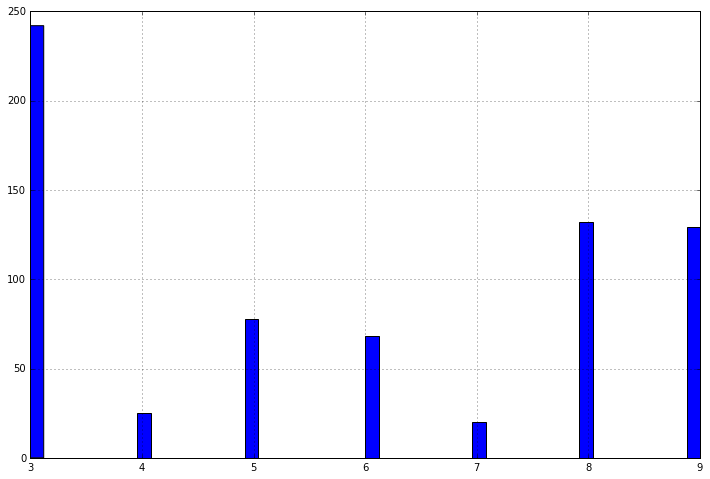

In [145]:
# mostra a distribuição da idade das transferências
filtro_convenios_final['idadeTransf'].hist(bins=50, figsize=(12,8))

In [146]:
grupo_UF = filtro_convenios_final.groupby(['UF'])
grupo_UF['Valor Convênio'].agg(['sum', 'count'])

                               sum  count
UF                                       
ALAGOAS             135,598,911.88     21
BAHIA               209,662,578.36     50
CEARA               598,390,450.92    162
MARANHAO            284,633,189.14    114
PARAIBA             286,641,179.41     97
PERNAMBUCO          252,211,991.85     72
PIAUI               295,374,047.22     92
RIO GRANDE DO NORTE 225,804,980.71     64
SERGIPE             153,554,902.95     22

### Convênios por estado e por função

                                                  sum
UF                  Função (Descrição)               
ALAGOAS             EDUCACAO             4,800,952.35
                    SANEAMENTO           8,060,312.04
                    SAUDE              122,737,647.49
BAHIA               EDUCACAO            11,240,117.04
                    SANEAMENTO          51,137,280.63
                    SAUDE              147,285,180.69
CEARA               EDUCACAO            15,641,655.08
                    SANEAMENTO         115,996,997.81
                    SAUDE              466,751,798.03
MARANHAO            EDUCACAO             2,396,566.84
                    SANEAMENTO          32,238,289.29
                    SAUDE              249,998,333.01
PARAIBA             EDUCACAO             6,610,856.52
                    SANEAMENTO          14,106,779.84
                    SAUDE              265,923,543.05
PERNAMBUCO          EDUCACAO             8,924,045.87
                    SANEAMEN

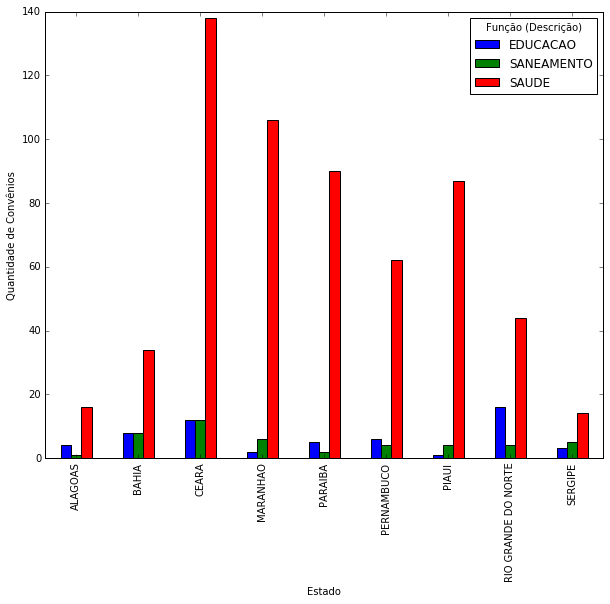

In [147]:
grupo_UF_funcao = filtro_convenios_final.groupby(['UF','Função (Descrição)'])
grupo_UF_funcao['Valor Convênio'].agg(['sum', 'count'])
grafico_UF_Funcao = grupo_UF_funcao.size().unstack().plot(kind='bar', figsize=(10, 8))
grafico_UF_Funcao.set_xlabel("Estado")
grafico_UF_Funcao.set_ylabel("Quantidade de Convênios")
grupo_UF_funcao['Valor Convênio'].agg(['sum'])

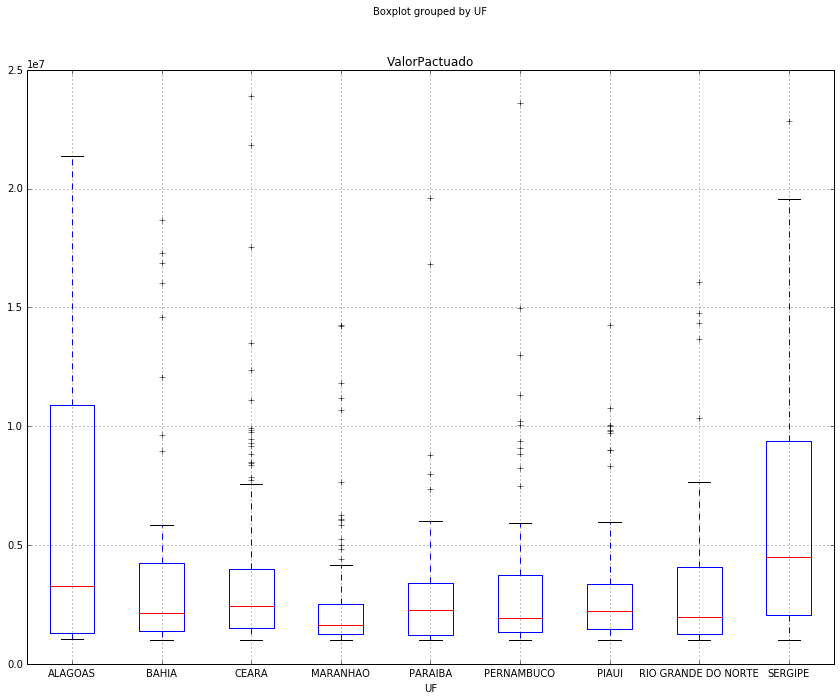

In [148]:
filtro_convenios_final.boxplot(column='ValorPactuado', by='UF', figsize=(14,11))

## 1º Produto: Listagem dos Convênios de Obras do Nordeste
<img src="files/Figuras/folder data.png" align="left" height="80" width="80">

In [149]:
filtro_convenios_final.to_excel('Listagem_Convenios_Obras.xlsx')

## Convênios após os filtros

In [150]:
print('Total de Convênios Municipais ->', len(filtro_convenios_final))
filtro_convenios_final.groupby('Situação Convênio')['Situação Convênio'].count()

Total de Convênios Municipais -> 694


Situação Convênio
Adimplente                505
Em Execução                65
Inadimplente               62
Inadimplência Suspensa     62
Name: Situação Convênio, dtype: int64

# Análises dos convênios após os filtros -- a implementar

##  <img src="files/Figuras/OBRAS.png" align="left" height="90" width="90">  2º Etapa: Situação das Obras após junção com outras fontes de dados: Caixa, Funasa, Simec e Portal da  Transparência


### FUNASA: Lê e ajusta os dados do arquivo de obras

In [151]:
dados_funasa = importaMontaArquivosNordeste(nome_geral_arquivo_funasa, 'excel', 7)
ajustaDadosFunasa(dados_funasa)

### Os dados da Funasa relativos ao Nordeste contém 7.870 registros de obras dos 9 estados

In [152]:
print(len(dados_funasa))
dados_funasa.info()

8055
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8055 entries, 0 to 1009
Data columns (total 25 columns):
NM_UF                          8055 non-null object
CONVENIO                       8055 non-null object
SIAFI                          8055 non-null int32
INSTRUMENTO                    8055 non-null object
PROPOSTA_SICONV                1367 non-null object
CONVENIO_SICONV                1398 non-null object
PROCESSO                       8054 non-null object
ACAO                           8055 non-null object
LOCALIZACAO_PROCESSO_SCDWEB    8055 non-null object
TOMADOR_NOME                   8055 non-null object
TOMADOR_CNPJ                   8055 non-null int64
UF_MUNICIPIO_BENEFICIADO       8050 non-null object
DATA_ASSINATURA                8049 non-null datetime64[ns]
DATA_INICIO_VIGENCIA           8055 non-null datetime64[ns]
DATA_FIM_VIGENCIA              8055 non-null datetime64[ns]
VALOR_EMPREENDIMENTO           8012 non-null float64
VALOR_CONTRAPARTIDA            80

### Join dos dados da Funasa com os convênios DGI

In [153]:
# junta o arquivo da DGI com o da FUNASA
join_dgi_funasa = pd.merge(filtro_convenios_final, dados_funasa, on='SIAFI', how='left')
#join_dgi_funasa.to_excel('join_funasa_dgi_outer.xlsx')
# converte novamente o código do SIAFI para int
join_dgi_funasa['SIAFI'] = join_dgi_funasa['SIAFI'].astype(int)

### cria um sub conjunto do join contendo apenas os campos que desejamos

### SIMEC: Lê e ajusta os dados do arquivo

### Arquivo baixado do portal http://simec.mec.gov.br/painelObras/ com dados de todas as obras do Brasil

In [154]:
dados_simec = importaAjustaDadosSIMEC()

In [155]:
dados_simec.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11948 entries, 0 to 28622
Data columns (total 13 columns):
NumeroOriginalConvenio                            11270 non-null object
cnpj_contratata                                   9138 non-null object
UF                                                11948 non-null object
Município                                         11948 non-null object
Situação                                          11945 non-null object
Percentual de Execução                            11948 non-null float64
Valor do Contrato                                 10704 non-null float64
Prazo de Vigência                                 9439 non-null float64
Data Prevista de Conclusão da Obra                8000 non-null datetime64[ns]
Data da Última Vistoria do Estado ou Município    8972 non-null datetime64[ns]
Saldo TOTAL                                       10849 non-null float64
Total Pago                                        8208 non-null float64
Percentual 

### O simec registra que há 11.846 registros de obras de educação no nordeste

### Join dos dados do Simec com o join anterior (DGI, Funasa, Portal da Transparência)

In [156]:
# junta os dataframes
join_dgi_funasa_portal_simec = pd.merge(join_dgi_funasa, dados_simec, on='NumeroOriginalConvenio', how='left')

### Temos 93 registros correspondentes no simec, devido ao fato de que 1(um) convênio pode dar origem a várias obras - O Join está correto

### CAIXA: Lê e ajusta os dados do arquivo de obras fornecido pela Gigov PB

In [157]:
dados_caixa = importaAjustaArqCaixaPB()
# Mostra os campos e seus tipos
dados_caixa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 14 columns):
CONTRATO                      208 non-null object
SIAFI                         208 non-null int32
PROPONENTE                    208 non-null object
CNPJ                          208 non-null object
LOCALIDADE                    208 non-null object
VALOR_INVESTIMENTO            208 non-null float64
REPASSE_DESBLOQUEADO          208 non-null float64
CONTRAPARTIDA_DESBLOQUEADA    208 non-null float64
TOTAL_DESBLOQUEADO            208 non-null float64
SITUACAO_CONTRATO             208 non-null object
Situação_Obra_Caixa           205 non-null object
%_EXECUTADO                   208 non-null float64
VIGENCIA                      205 non-null datetime64[ns]
SITUAÇÃO E GESTÃO             208 non-null object
dtypes: datetime64[ns](1), float64(5), int32(1), object(7)
memory usage: 22.0+ KB


## Min. Cidades: Lê e ajusta o arquivo fornecido pelo Ministério das Cidades

In [158]:
dados_cidades = importaAjustaAqrMinCidades()

In [159]:
dados_cidades.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359 entries, 0 to 358
Data columns (total 18 columns):
RECURSO OGU             359 non-null object
CONTRATO                359 non-null object
SIAFI                   359 non-null int64
PROPOSTA_SICONV         359 non-null int64
UF                      359 non-null object
MUNICIPIO               355 non-null object
DT_ASSINATURA           359 non-null datetime64[ns]
DT_AUT_INICIO_CAIXA     201 non-null datetime64[ns]
DT_INICIO_OBRA          198 non-null datetime64[ns]
DT_FIM_OBRA             190 non-null datetime64[ns]
DT_VISTORIA             60 non-null datetime64[ns]
VLR_REPASSE             359 non-null float64
VLR_LIBERADO            359 non-null float64
VLR_DESBLOQUEADO        359 non-null float64
SIT_CONTRATO            359 non-null object
SIT_OBRA                359 non-null object
PERCENTUAL_REALIZADO    359 non-null float64
CNPJ_CONTRATADAS        190 non-null object
dtypes: datetime64[ns](5), float64(4), int64(2), object(7)
mem

### Faz a junção do arquivo da Caixa da PB com o Join anterior (DGI + FUNASA + PORTAL + SIMEC + CAIXA)

In [160]:
# junta os dataframes
join_DFPSC = pd.merge(join_dgi_funasa_portal_simec, dados_caixa, on='SIAFI', how='left')

### Faz  a junção do arquivo do Min. Cidades com o Join anterior (SGI + FUNASA + PORTAL + SIMEC + CAIXA + CIDADES)

In [161]:
join_DFPSCC = pd.merge(join_DFPSC, dados_cidades, on='SIAFI', how='left')

### Cria uma coluna para receber todos os percentuais de execução da obra para permitir a elaboração de estatísticas

In [162]:
# Percentual informado pela FUNASA
join_DFPSCC['PERCENTUAL_EXEC_OBRA'] = np.where(join_DFPSCC['PERCENTUAL_OBRA'].isnull(),np.nan,join_DFPSCC['PERCENTUAL_OBRA'])
# Percentual informado pelo Simec
join_DFPSCC['PERCENTUAL_EXEC_OBRA'] = np.where(join_DFPSCC['Percentual de Execução'].isnull(),join_DFPSCC['PERCENTUAL_EXEC_OBRA'],join_DFPSCC['Percentual de Execução'])
# Percentual informado pela Caixa
join_DFPSCC['PERCENTUAL_EXEC_OBRA'] = np.where(join_DFPSCC['%_EXECUTADO'].isnull(),join_DFPSCC['PERCENTUAL_EXEC_OBRA'],join_DFPSCC['%_EXECUTADO'])
# Percentual informado pelo Min. Cidades
join_DFPSCC['PERCENTUAL_EXEC_OBRA'] = np.where(join_DFPSCC['PERCENTUAL_REALIZADO'].isnull(),join_DFPSCC['PERCENTUAL_EXEC_OBRA'],join_DFPSCC['PERCENTUAL_REALIZADO'])

In [163]:
join_DFPSCC['SITUACAO_EXEC_OBRA'] = join_DFPSCC.apply(pegaSituacaoObra, axis=1)

### Cria campo de Percentual Liberado em relação ao valor total do Convênio

In [164]:
join_DFPSCC['Percentual_liberado'] = join_DFPSCC['Valor Liberado'] / join_DFPSCC['Valor Convênio']

### Coloca um sinalizador de convênios com alto risco de possuir problemas

### Condições: 
### 1. Data da última liberação a mais de dois anos 2. Obras não concluídas  3. Valor liberado ultrapassa 50% do valor do convênio 4. Classificada no sistema como Atrasada Paralisada ou Abandonada

In [165]:
condicao_alto_risco = ((hoje.year - join_DFPSCC['Data Última Liberação'].dt.year > 2) & (join_DFPSCC['SITUACAO_EXEC_OBRA'] != 'Concluída') & (join_DFPSCC['Percentual_liberado'] >= 0.5)) | (join_DFPSCC['SITUACAO_EXEC_OBRA'].str.contains('Atrasada|Paralisada|Inacabada'))
                      

In [166]:
join_DFPSCC['alto_risco'] = np.where(condicao_alto_risco,1, 0)

## 2º Produto: Listagem de Convênios com alto risco de apresentar problemas
<img src="files/Figuras/folder data.png" align="left" height="80" width="80">

In [167]:
join_DFPSCC.to_excel('join_DFSPCC_Obras.xlsx')

### Situação Geral das Obras em relação a sua situação

In [168]:
grupo_Situacao_Obra_geral = join_DFPSCC.groupby(['SITUACAO_EXEC_OBRA'])
grupo_Situacao_Obra_geral['SITUACAO_EXEC_OBRA'].agg(['count'])

                    count
SITUACAO_EXEC_OBRA       
                       91
Atrasada                9
Concluída             123
Em Execução           271
Inacabada               9
Não Iniciada           86
Paralisada            120

### Trabalha apenas os Convênios de Alto Risco

In [169]:
obras_risco = join_DFPSCC[join_DFPSCC['alto_risco'] == 1]

In [170]:
obras_risco['SITUACAO_EXEC_OBRA'].unique()

array(['Inacabada', '', 'Em Execução', 'Paralisada', 'Atrasada',
       'Não Iniciada'], dtype=object)

In [171]:
grupo_Situacao_Obra = obras_risco.groupby(['SITUACAO_EXEC_OBRA'])
grupo_Situacao_Obra['SITUACAO_EXEC_OBRA'].agg(['count'])

                    count
SITUACAO_EXEC_OBRA       
                       21
Atrasada                9
Em Execução            66
Inacabada               9
Não Iniciada            1
Paralisada            120

### Trabalha apenas com os Convênios classificados como em Execução

In [172]:
obras_risco = obras_risco[obras_risco['SITUACAO_EXEC_OBRA']== 'Em Execução']

### Verifica a Distribuição do % de Execução das Obras

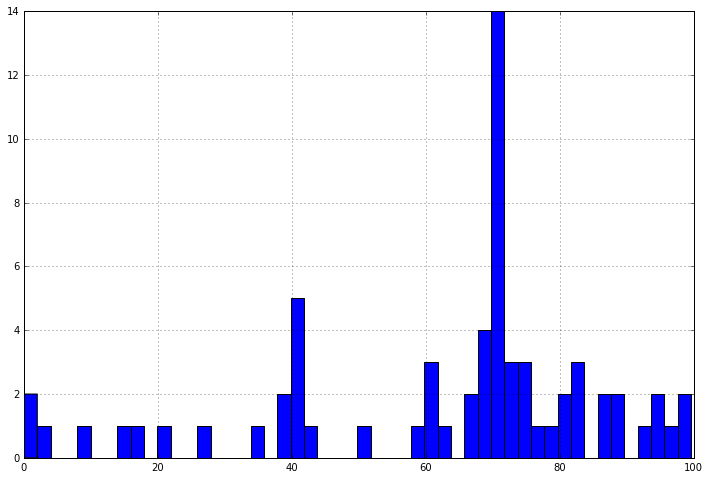

In [173]:
# mostra a distribuição da idade das transferências
obras_risco['PERCENTUAL_EXEC_OBRA'].hist(bins=50, figsize=(12,8))

In [174]:
obras_risco['PERCENTUAL_EXEC_OBRA'].describe()

count   66.00
mean    62.57
std     24.79
min      0.00
25%     44.30
50%     70.00
75%     76.23
max     99.62
Name: PERCENTUAL_EXEC_OBRA, dtype: float64

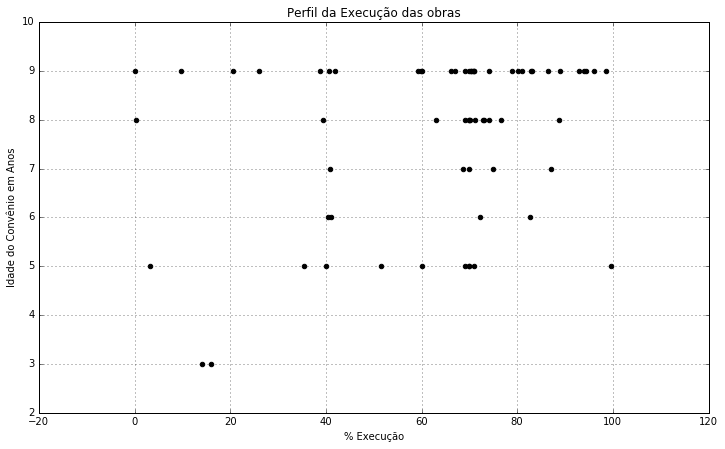

In [175]:
scatter_plot1 = obras_risco.plot(kind='scatter',
                                       x='PERCENTUAL_EXEC_OBRA',
                                       y='idadeTransf',
                                       figsize=(12,7), grid=True, 
                                       title='Perfil da Execução das obras',
                                                                         c='black')
scatter_plot1.set_xlabel('% Execução')
scatter_plot1.set_ylabel('Idade do Convênio em Anos')

##  <img src="files/Figuras/fantasma.jpg" align="left" height="90" width="90">  3º Etapa: Empresas identificação de possíveis empresas fantasmas

### Cruza os CNPJs das contratadas da Paraíba com a lista de empresas que caíram em operações da PF e do MPE-PB

In [176]:
contratadas_pb = pd.read_csv(os.path.join(path_cruzamentos_empresas, 'Contratadas_PB.csv'), 
                                          sep=';',
                                          encoding='ISO-8859-1',
                                          converters={'CNPJ': str})
empresas_Operacoes_PF = pd.read_csv(os.path.join(path_cruzamentos_empresas, 'Empresas_Operacoes_PF.csv'), 
                                    sep=';', 
                                    encoding='ISO-8859-1',
                                    converters={'CNPJ': str})
empresas_GAECO = pd.read_csv(os.path.join(path_cruzamentos_empresas, 'Empresas_GAECO.csv'),
                              sep=';',
                              encoding='ISO-8859-1',
                              converters={'CNPJ': str})

## Empresas contratadas na Paraiba que caíram em operações da PF

In [177]:
join_contratadas_PF = pd.merge(contratadas_pb, empresas_Operacoes_PF, on='CNPJ', how='inner')

In [178]:
empresas_Operacoes_PF

                                          Razão Social             CNPJ          Operação
0                           A & G PROMOCOES ARTISTICAS    3555965000139       PÃO E CIRCO
1                                        ADJ PRODUCOES    9176668000169       PÃO E CIRCO
2                       AGUIA DOURADA ENGENHARIA LTDA.    2607205000165      I-LICITAÇÕES
3                              ALSERV CONSTUTORA LTDA.    8708095000104       GARPARZINHO
4          ALTAS CONSTRUCOES PROJETOS E SERVICOS LTDA    10377336000121     TRANSPARÊNCIA
5                 AMERICA CONSTRUCOES E SERVICOS LTDA.    5492161000163      I-LICITAÇÕES
6                       APE ABILIO PRODUCOES E EVENTOS    4740678000161       PÃO E CIRCO
7       ARAPUAN COMERCIO, REPRESENTACAO E SERVICO LTDA    3086588000136     CARTA MARCADA
8                           ARCO IRIS CONSTRUTORA LEDA    6943110000173     TRANSPARÊNCIA
9              ASTECA CONSTRUCOES E INCORPORACOES LTDA    8953750000190     TRANSPARÊNCIA
10        

In [179]:
join_contratadas_PF[['CNPJ','Razão Social_x', 'Operação']]

             CNPJ                        Razão Social_x       Operação
0  10749194000186   Prumos Construcoes E Servicos Ltda         Andaime
1   3086586000147  Consbrasil - Construtora Brasil Ltda  TRANSPARÊNCIA
2   2735064000166     HIDROGEO PROJETOS E SERVIÇOS LTDA  TRANSPARÊNCIA
3  12396152000134                    WJ ENGENHARIA LTDA        Andaime

## Empresas que constam da lista de empresas suspeitas enviada pelo GAECO

In [180]:
empresas_GAECO =  empresas_GAECO[['CNPJ', 'NOME_CREDOR', 'NOME_FANTASIA', 'SIT_CADAST']]

In [181]:
join_GAECO = pd.merge(contratadas_pb, empresas_GAECO, on='CNPJ', how='inner')

In [182]:
# remove os duplicados
join_GAECO = join_GAECO.drop_duplicates('CNPJ', keep='first')

In [183]:
join_GAECO[['CNPJ', 'NOME_CREDOR', 'Razão Social']]

              CNPJ                                        NOME_CREDOR                                      Razão Social
0   10749194000186            PRUMOS CONSTRUCOES E SERVICOS LTDA - ME               Prumos Construcoes E Servicos Ltda 
1    5463105000109                       CAMAT CONSTRUTORA LTDA - EPP                            CAMAT CONSTRUTORA LTDA
2    3503388000131   COMPECC ENGENHARIA, COMERCIO E CONSTRUCOES LTDA.   COMPECC ENGENHARIA COMÉRCIO E CONSTRUÇÕES LTDA.
3    3086586000147               CONSBRASIL - CONSTRUTORA BRASIL LTDA              Consbrasil - Construtora Brasil Ltda
4    5219643000144              CONSERV - CONSTRUCOES E SERVICOS LTDA               CONSERV CONSTRUÇÕES E SERVIÇOS LTDA
5   11322888000103    CONSTRUTORA E METALURGICA VASCONCELOS LTDA - ME        CONSTRUTORA E MATALURGICA VASCONCELOS LTDA
6    4667686000120                    CONSTRUTORA GONCALVES LTDA - ME                        CONSTRUTORA GONCALVES LTDA
7    5962039000103               COPAL E

## Empresas da Operação Andaime - GAECO

In [184]:
empresas_Operação_Andaime = pd.read_csv(os.path.join(path_cruzamentos_empresas, 'Empresas_Operacao_Andaime.csv'),
                                    sep=';', 
                                    encoding='ISO-8859-1',
                                    converters={'CNPJ': str})

### Retuira a máscara do CNPJ para permitir o cruzamento dos dados

### Faz o Join da nossa lista de empresas contratadas para realizar as obras dos convênios com as empresas da operação ANDAIME

In [185]:
join_contratadas_Andaime = pd.merge(contratadas_pb, empresas_Operação_Andaime, on='CNPJ', how='inner')

In [186]:
join_contratadas_Andaime

             CNPJ                          Razão Social                                    RAZÃO
0  10749194000186   Prumos Construcoes E Servicos Ltda   Prumos Construções E Serviços Ltda  ME
1  12396152000134                    WJ ENGENHARIA LTDA                  WJ Engenharia Ltda  ME

### Faz o Join das empresas contratadas que encontramos com a RAIS

In [187]:
# pega o nome completo do arquivo da RAIS
nome_arq_rais = os.path.join(path_cruzamentos_empresas_geral, 'rais_estabelecimento.csv')
# carrega o arquivo da RAIS que veio do DGI
rais_estabelecimento = pd.read_csv(nome_arq_rais, sep=';', encoding='ISO-8859-1')
# renomeia o CNPJ 
rais_estabelecimento.rename(columns={'CNPJEstab.':'CNPJ'}, inplace=True)
# agrupa para contar 

In [188]:
# Pega os dados da RAIS 
#rais_estabelecimento = rais_estabelecimento[rais_estabelecimento['AnoRais'] == 2015]]

In [189]:
#rais_estabelecimento[['Razão Social do Estabelecimento', 'Qte.VínculoEstab.']]

In [190]:
#grupo['CNPJ'].count().sort_values()

### Sócios das empresas que constam no CADÚNICO

In [191]:
# carrega o arquivo que contém os sócios das empresas constratadas
socios_contratadas = pd.read_csv(os.path.join(path_cruzamentos_empresas_geral, 'cruzamento_cnpj_Socios.csv'), 
                      sep=';',
                      encoding='ISO-8859-1', 
                      converters={'CPFSócio': str})

In [192]:
socios_contratadas.rename(columns={'CPFSócio':'CPF'}, inplace=True)

In [193]:
socios_cad_UNICO =  pd.read_csv(os.path.join(path_cruzamentos_empresas_geral, 'cruzamento_cpf_socios_CAD_UNico.csv'), 
                      sep=';',
                      encoding='ISO-8859-1', 
                      converters={'CPF': str})

### Junta os dados dos sócios com os dados do cruzamento com o CAD ÚNICO

In [194]:
join_socios_cad_UNICO = pd.merge(socios_contratadas, socios_cad_UNICO, on='CPF', how='inner')

### Lista completa de sócios que estão no CADÚNICO

In [195]:
join_socios_cad_UNICO[['CPF', 'Nome Completo (no CPF)', 'EstadoCadastro', 'Nome / Razão Social (no CNPJ)']]

           CPF             Nome Completo (no CPF) EstadoCadastro                    Nome / Razão Social (no CNPJ)
0    754519481        IVANILDA VIEGAS DE OLIVEIRA     Cadastrado             CONSBRASIL - CONSTRUTORA BRASIL LTDA
1   9816631415            SEVERINO JOSE ALEXANDRE     Cadastrado             CONSBRASIL - CONSTRUTORA BRASIL LTDA
2   9894440401       MICHAEL SANTOS DO NASCIMENTO       Excluído                    QUARTZO CONSTRUCOES LTDA - ME
3   9894440401       MICHAEL SANTOS DO NASCIMENTO       Excluído                    QUARTZO CONSTRUCOES LTDA - ME
4   9894440401       MICHAEL SANTOS DO NASCIMENTO       Excluído                    QUARTZO CONSTRUCOES LTDA - ME
5   9894440401       MICHAEL SANTOS DO NASCIMENTO       Excluído                    QUARTZO CONSTRUCOES LTDA - ME
6   9894439497  MARCELO JOSE SANTOS DO NASCIMENTO       Excluído                    QUARTZO CONSTRUCOES LTDA - ME
7   9894439497  MARCELO JOSE SANTOS DO NASCIMENTO       Excluído                    QUAR

###  Retira os cadastros excluídos

In [196]:
join_socios_cad_UNICO = join_socios_cad_UNICO[join_socios_cad_UNICO['EstadoCadastro'] == 'Cadastrado']

### Lista de Sócios que estão com cadastros ativos no CADÚNICO

In [197]:
join_socios_cad_UNICO[['CPF', 'Nome Completo (no CPF)', 'EstadoCadastro', 'Nome / Razão Social (no CNPJ)']]

           CPF           Nome Completo (no CPF) EstadoCadastro                    Nome / Razão Social (no CNPJ)
0    754519481      IVANILDA VIEGAS DE OLIVEIRA     Cadastrado             CONSBRASIL - CONSTRUTORA BRASIL LTDA
1   9816631415          SEVERINO JOSE ALEXANDRE     Cadastrado             CONSBRASIL - CONSTRUTORA BRASIL LTDA
10  6013748438  ALYSON PAULINELY LEITE DE SOUSA     Cadastrado          PRUMOS CONSTRUCOES E SERVICOS LTDA - ME
11  8538504452        MOISES LUCENA SOUZA SOUTO     Cadastrado  CONSTRUTORA E METALURGICA VASCONCELOS LTDA - ME

In [198]:
join_socios_cad_UNICO[['CPF', 'Nome Completo (no CPF)', 'EstadoCadastro', 'Nome / Razão Social (no CNPJ)']].to_excel('Socios_CAD_UNICO.xlsx')

##  <img src="files/Figuras/movimentacoes.png" align="left" height="90" width="90"> 4ª Etapa - Movimentações Financeiras Atípicas

### Lê os arquivos com os dados das contas dos municípios e do extrato da conta dos Convênios

In [199]:
# Lê o arquivo das contas dos Municípios que foi extraído do SAGRES
contas_municipios =  pd.read_csv(os.path.join(path_movimentacoes_financeiras, 'Contas_Municipios_CSV.csv'),
                                 sep=';', 
                                 encoding='ISO-8859-1')

In [200]:
extrato_conta_convenios = pd.read_csv(os.path.join(path_movimentacoes_financeiras, 'Extrato das Contas Bancarias.csv'),
                                 sep=';', 
                                 encoding='ISO-8859-1')

In [201]:
contas_municipios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2085 entries, 0 to 2084
Data columns (total 6 columns):
Banco         2085 non-null int64
Agência       2085 non-null object
Nº Conta      2085 non-null object
Conta         2085 non-null object
Saldo (R$)    2085 non-null object
Município     2085 non-null object
dtypes: int64(1), object(5)
memory usage: 97.8+ KB


### Remove os caracteres não numéricos do campo agência e conta para poder transformá-los em numérico

In [202]:
contas_municipios['Agência'] = contas_municipios.apply(removeNaoNumeroAgencia, axis=1)

In [203]:
contas_municipios['Agência'] = contas_municipios['Agência'].astype('int')

In [204]:
# renomeia para fazer o Join
contas_municipios.rename(columns={'Agência':'AGENCIA'}, inplace=True)

In [205]:
contas_municipios.rename(columns={'Nº Conta':'CONTA'}, inplace=True)

In [206]:
contas_municipios['CONTA'] = contas_municipios.apply(removeNaoNumeroConta, axis=1)

In [207]:
contas_municipios['CONTA'] = contas_municipios['CONTA'].astype('float')

In [208]:
join_contas_extratos = pd.merge(extrato_conta_convenios, contas_municipios, how='inner', on=['AGENCIA', 'CONTA'] )

In [209]:
join_contas_extratos.to_excel('join_contas_extratos.xlsx')